# Using DeepAR to Forecast Electricity Time Series Data <a name="toc"></a>

**Estimated time: 35 min**

DeepAR is a supervised learning algorithm for forecasting scalar time series. In this notebook, you will use DeepAR to forecast the electricity demand (across different dimensions) based on a time series of past consumption. 

This notebook demonstrates how to prepare a time series dataset for training DeepAR and how to use the trained model for inference. This content was designed to run from within an Amazon SageMaker `ml.m4.xlarge` instance.

**Table of Contents:** 

1. [Getting Started](#start)
1. [Real Data Set : Electricity Consumption](#data)
    1. [Partition the Data into Training and Test Sets](#split)
    1. [Visualize the Time Series](#visualize)
    1. [Amazon S3 Data Formatting](#s3)
1. [DeepAR: LSTM & Monte Carlo](#deepar)
    1. [Train the Model](#fit)
    1. [Create Endpoint and Predictor](#endpoint)
1. [Make Predictions and Plot Results](#predict)
1. [Delete Endpoint](#delete)

# Getting Started <a name="start"></a>

To complete this lab, carefully move through this notebook, from top to bottom, making sure to read all text instructions/explanations and run each code cell in order. Also be sure to view the code cell outputs. To run each cell, step-by-step in the Jupyter notebook, click within the cell and press **SHIFT + ENTER** or choose **Run** at the top of the page. You will know that a code cell has completed running when you see a number inside the square brackets located to the left of the code cell. Alternatively, **[ ]** indicates the cell has yet to be run, and **[*]** indicates that the cell is still processing.

Get started with this lab by installing the necessary libraries below.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [1]:
import time
whole_start = time.time()
import numpy as np
np.random.seed(1)

Use the Amazon Sagemaker client library for easy interface with the AWS service and `s3fs` for uploading the training data to Amazon S3.

(As a side note, not directly related to this lab, you could use `pip` to install missing libraries when necessary.)

In [2]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

Start by specifying:
- The Amazon S3 bucket and prefix that you want to use for the training and model data. This should be within the same region as the notebook, training, and hosting instances. The 'LAB_BUCKET' name that you need to fill in below can be found in Qwiklabs along the left-hand side, under *LabBucket*. Just copy and paste that bucket name into the appropriate location in the code cell below before running the cell. 
- The IAM role ARN is used to give training and hosting access to your data. See the documentation for how to create these. Here, the `get_execution_role` function obtains the role ARN, which was specified when creating the notebook.

In [10]:
bucket = 'sagemaker-us-west-2-540188452820'
prefix = 'demos/deepar/forecast-electricity'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)
print('Data location: %s'%s3_data_path)
print('Output location: %s'%s3_output_path)

Data location: sagemaker-us-west-2-540188452820/demos/deepar/forecast-electricity/data
Output location: sagemaker-us-west-2-540188452820/demos/deepar/forecast-electricity/output


# Real Data Set: Electricity Consumption <a name="data"></a>

**Dataset License and Information:**

For this lab, you will be using an open source dataset entitled, [“Individual Household Electric Power Consumption”](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption) that comes from the UCI Machine Learning Repository. Information about the dataset license can be found below. 

The MIT License (MIT) Copyright © [2017] Zalando SE, [https://tech.zalando.com](https://tech.zalando.com). 

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE. 

This archive contains 2,075,259 measurements gathered between December 2006 and November 2010 (47 months). 

**Notes:**

1. (Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. 
2. The dataset contains some missing values in the measurements (nearly 1.25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**Attribute Information:**

1. `Date`: Date in format dd/mm/yyyy 
2. `Time`: Time in format hh:mm:ss 
3. `Global_active_power`: Household global minute-averaged active power (in kilowatt) 
4. `Global_reactive_power`: Household global minute-averaged reactive power (in kilowatt) 
5. `Voltage`: Minute-averaged voltage (in volt) 
6. `Global_intensity`: Household global minute-averaged current intensity (in ampere) 
7. `Sub_metering_1`: Energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the `kitchen`, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
8. `Sub_metering_2`: Energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the `laundry room`, containing a washing machine, a tumble-drier, a refrigerator and a light. 
9. `Sub_metering_3`: Energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an `electric water-heater` and an `air-conditioner`.

With the above information as context, now retrieve and read the data.

#### 日期：日期格式為dd / mm / yyyy
#### 時間：格式為時間hh：mm：ss
#### Global_active_power：家庭全球分鐘平均有功功率（千瓦）
#### Global_reactive_power：家庭全球分鐘平均無功功率（千瓦）
#### 電壓：分鐘平均電壓（以伏特為單位）
#### Global_intensity：家庭全球分鐘平均電流強度（安培）
#### Sub_metering_1：1號能量分計量（以瓦特小時為單位的有功電能）。它對應於廚房，主要包括洗碗機，烤箱和微波爐（熱板不是電動的，而是燃氣動力的）。
#### Sub_metering_2：2號能量分計量（以瓦特小時為單位的有功電能）。它對應於洗衣房，包括洗衣機，滾筒式烘乾機，冰箱和燈。
#### Sub_metering_3：能量分計量3號（以有功電能的瓦特小時計）。它對應於電熱水器和空調。
<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [11]:
FILENAME = 'household_power_consumption.txt'

import os
if not os.path.isfile(FILENAME):
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
    !unzip household_power_consumption.zip

import pandas as pd
raw = pd.read_csv(FILENAME, sep=';', parse_dates=True, na_values=['?'])
raw.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Convert the Index of the Time Series to `DatetimeIndex`

In order for DeepAR to model seasonalities effectively, the algorithm expects the time index in `DateTime` format. Additionally, all time series in the dataset have to have the same frequency.

In [12]:
import datetime
raw['DateTime'] = (raw['Date']+' '+raw['Time']).map(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y %H:%M:%S') )
raw.drop(['Date','Time'], axis=1, inplace=True)

cols_float = raw.drop('DateTime',axis=1).columns
raw[cols_float] = raw[cols_float].apply(lambda x: x.astype(float))
raw = raw.set_index('DateTime')

print('Percentage of missing data at minute-granularity: %2.2f%%' %(100*raw.isnull().mean().mean()) )

Percentage of missing data at minute-granularity: 1.25%


### DeepAR Handles Missing Data

1.25% of the data at minute-granularity is missing. 分鐘數值遺失

Since minute-forecasts are not necessary, you will roll up to hour-granularity. This roll-up incidentally alleviates the missing values in your data. However, DeepAR is able to handle missing data: [DeepAR supports missing values, categorical and time series features, and generalized frequencies](https://aws.amazon.com/blogs/machine-learning/amazon-sagemaker-deepar-now-supports-missing-values-categorical-and-time-series-features-and-generalized-frequencies/).

In [13]:
freq = '2H'
df = raw.resample(freq, convention='end').sum()
print('Percentage of missing data at hour-granularity:: %2.2f%%' %(100*df.isnull().mean().mean()) )
display(df.head())

Percentage of missing data at hour-granularity:: 0.00%


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 16:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,421.946,9.916,28068.76,1806.2,0.0,489.0,2013.0
2006-12-16 20:00:00,379.502,9.106,28273.81,1617.8,0.0,25.0,2040.0
2006-12-16 22:00:00,255.704,7.656,28762.78,1105.2,0.0,13.0,266.0
2006-12-17 00:00:00,313.912,14.362,28884.61,1342.4,0.0,1542.0,0.0


# Partition the Data into Training and Test Sets  <a name="split"></a>

In this example, you want to train a model that can predict the next **1 week** of electricity time series usage. Since your time series has hourly granularity, 1 week is equivalent to 168 hours. 預測下一週, 以小時作為刻度, 共有168小

You also need to configure the so-called `context_length`, which determines how much context of the time series the model should take into account when making the prediction, i.e. how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`. In practice, it is often beneficial to use a longer `context_length`. In addition to the `context_length` the model also takes into account the values of the time series at typical seasonal windows. For instance, for hourly data, the model will look at the value of the series 24 hours ago, one week ago, one month ago, etc. Therefore, it is not necessary to make the `context_length` span an entire month if you expect monthly seasonalities in your hourly data.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [14]:
prediction_length = int(7*24/int(freq.replace('H','')))
context_length = int(7*24/int(freq.replace('H','')))

print('Preditction length: %i %s' %(prediction_length, freq))
print('Context length: %i %s' %(context_length, freq))
print('-->  1 week')

n_weeks = 6
end_training = df.index[-n_weeks*prediction_length]

time_series = []
for ts in df.columns:
    time_series.append(df[ts])
    
time_series_training = []
for ts in df.columns:
    time_series_training.append(df.loc[:end_training][ts])

Preditction length: 84 2H
Context length: 84 2H
-->  1 week


## Visualize the Time Series <a name="visualize"></a>

Often it is interesting to tune or evaluate the model by looking at error metrics on a hold-out set. For other machine learning tasks such as classification, one typically does this by randomly separating examples into train/test sets. For forecasting it is important to do this train/test split in time rather than by series.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

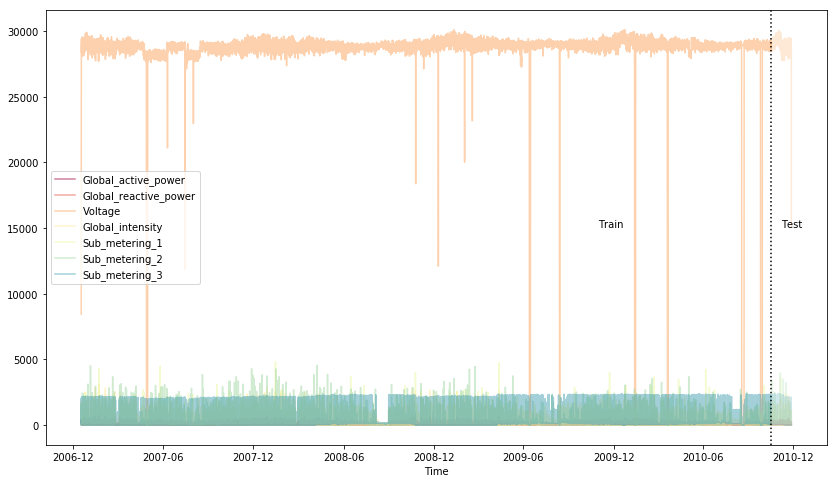

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

cmap = matplotlib.cm.get_cmap('Spectral')
colors = cmap(np.arange(0,len(cols_float))/len(cols_float))


plt.figure(figsize=[14,8]);
for c in range(len(cols_float)):
    plt.plot(df.loc[:end_training][cols_float[c]], alpha=0.5, color=colors[c], label=cols_float[c]);  
plt.legend(loc='center left');
for c in range(len(cols_float)):
    plt.plot(df.loc[end_training:][cols_float[c]], alpha=0.25, color=colors[c], label=None);
    #plt.plot(df[cols_float[c]], alpha=0.25, color=colors[c], linestyle=':', label=None);
plt.axvline(x=end_training, color='k', linestyle=':');
plt.text(df.index[int((df.shape[0]-n_weeks*prediction_length)*0.75)], df.max().max()/2, 'Train');
plt.text(df.index[df.shape[0]-int(n_weeks*prediction_length/2)], df.max().max()/2, 'Test');
plt.xlabel('Time');

## Amazon S3 Data Formatting <a name="s3"></a>

DeepAR supports JSON, gzipped JSON Lines, and Parquet. Use JSON strings for this lab. The following utility functions convert `pandas.Series` objects into the JSON format that DeepAR expects. Use these to write the data to S3.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [16]:
import json

def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

# DeepAR: LSTM & Monte Carlo <a name="deepar"></a>

Amazon SageMaker DeepAR is a methodology for producing accurate probabilistic forecasts, based on training an auto-regressive recurrent network model on a large number of related time series. DeepAR produces more accurate forecasts than other state-of-the-art methods, while requiring minimal manual work.

* The DeepAR algorithm first tailors a `Long Short-Term Memory` (LSTM)-based recurrent neural network architecture to the data. DeepAR then produces probabilistic forecasts in the form of `Monte Carlo` simulation. 
* `Monte Carlo` samples are empirically generated pseudo-observations that can be used to compute consistent quantile estimates for all sub-ranges in the prediction horizon.
* DeepAR also uses item-similarity to handle the `Cold Start` problem, which is to make predictions for items with little or no history at all.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

## Train the Model <a name="fit"></a>

Next, configure the container image to be used for the region in which your notebook is running, and define the estimator that will launch the training job.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [17]:
region = sagemaker_session.boto_region_name
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='DeepAR-forecast-electricity',
    output_path="s3://" + s3_output_path
)

Next, set some hyperparameters: 


| Hyperparameters          | Value                     |
|--------------------------|---------------------------|
| epochs                   | 100                       |
| time granularity         | bi-hourly                 |
| domain                   | $\mathbb{R}^+,\mathbb{N}$ |
| number training examples | 8606                      |
| batch size               | 32                        |
| learning rate            | $1e-3$                    |
| LSTM layers              | 3                         |
| LSTM nodes               | 40                        |
| likelihood               | gaussian                  |

Refer to the documentation for a full description of the available parameters: [https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html). 

For example, you will elect the Gaussian likelihood model because you have real-valued data. Other likelihood models can also readily be used as long as samples from the distribution can cheaply be obtained and the log-likelihood and its gradients with respect to the parameters can be evaluated. For example:

- **Gaussian:** Use for real-valued data.
- **Beta:** Use for real-valued targets between 0 and 1 inclusive.
- **Negative-binomial:** Use for count data (non-negative integers).
- **Student-T:** An alternative for real-valued data that works well for bursty data.
- **Deterministic-L1:** A loss function that does not estimate uncertainty and only learns a point forecast.

In [18]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "100",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

estimator.set_hyperparameters(**hyperparameters)

You are now are ready to launch the training job. Amazon SageMaker will start an Amazon EC2 instance, download the data from Amazon S3, start training the model, and save the trained model.

If you provide the `test` data channel, as in this example, DeepAR will also calculate accuracy metrics for the trained model on this test dataset. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

**Note:** The next cell may take **4-6 minutes** to complete. You'll notice at the end that the `billable time` is only around ~150 seconds. This is because customers only pay for consumption of the resources, not the provisioning time.


You can follow the progress of the training job, either in the console at [AWS SageMaker Training Jobs page](https://console.aws.amazon.com/sagemaker/home?#/jobs), or in the output generated by the below cell. The cell below will also print training metrics, such as the validation error per epoch, as the job trains. These training metrics are then recorded in the [Amazon CloudWatch Logs](https://console.aws.amazon.com/cloudwatch/home?#logStream:group=/aws/sagemaker/TrainingJobs;prefix=DeepAR-forecast-electricity-2018;streamFilter=typeLogStreamPrefix).

In [19]:
%%time
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DeepAR-forecast-electricity-2019-03-14-06-24-05-797


2019-03-14 06:24:05 Starting - Starting the training job...
2019-03-14 06:24:21 Starting - Launching requested ML instances......
2019-03-14 06:25:25 Starting - Preparing the instances for training......
2019-03-14 06:26:21 Downloading - Downloading input data
2019-03-14 06:26:21 Training - Downloading the training image...
2019-03-14 06:26:54 Training - Training image download completed. Training in progress.
Arguments: train
[03/14/2019 06:26:57 INFO 140570704729920] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'li

[03/14/2019 06:27:13 INFO 140570704729920] Epoch[4] Batch[5] avg_epoch_loss=7.262228
[03/14/2019 06:27:13 INFO 140570704729920] Epoch[4] Batch [5]#011Speed: 177.87 samples/sec#011loss=7.262228
[03/14/2019 06:27:14 INFO 140570704729920] Epoch[4] Batch[10] avg_epoch_loss=7.123321
[03/14/2019 06:27:14 INFO 140570704729920] Epoch[4] Batch [10]#011Speed: 173.67 samples/sec#011loss=6.956632
[03/14/2019 06:27:14 INFO 140570704729920] processed a total of 328 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2380.6309700012207, "sum": 2380.6309700012207, "min": 2380.6309700012207}}, "EndTime": 1552544834.574918, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1552544832.194223}

[03/14/2019 06:27:14 INFO 140570704729920] #throughput_metric: host=algo-1, train throughput=137.772238307 records/second
[03/14/2019 06:27:14 INFO 140570704729920] #progress_metric: host=algo-1, completed 5 % of epochs
[03/14/2019 06:27:14 INFO 1405707

[03/14/2019 06:27:33 INFO 140570704729920] Epoch[12] Batch[10] avg_epoch_loss=6.769123
[03/14/2019 06:27:33 INFO 140570704729920] Epoch[12] Batch [10]#011Speed: 176.43 samples/sec#011loss=6.622189
[03/14/2019 06:27:33 INFO 140570704729920] processed a total of 341 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2381.732940673828, "sum": 2381.732940673828, "min": 2381.732940673828}}, "EndTime": 1552544853.85182, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1552544851.470028}

[03/14/2019 06:27:33 INFO 140570704729920] #throughput_metric: host=algo-1, train throughput=143.165968833 records/second
[03/14/2019 06:27:33 INFO 140570704729920] #progress_metric: host=algo-1, completed 13 % of epochs
[03/14/2019 06:27:33 INFO 140570704729920] best epoch loss so far
[03/14/2019 06:27:33 INFO 140570704729920] Saved checkpoint to "/opt/ml/model/state_eab3ffda-5eaa-4a87-8673-c5afd2a1d6d6-0000.params"
#metrics {"Metrics": {"stat

[03/14/2019 06:27:53 INFO 140570704729920] Epoch[21] Batch[5] avg_epoch_loss=6.535510
[03/14/2019 06:27:53 INFO 140570704729920] Epoch[21] Batch [5]#011Speed: 176.39 samples/sec#011loss=6.535510
[03/14/2019 06:27:54 INFO 140570704729920] processed a total of 295 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2182.8060150146484, "sum": 2182.8060150146484, "min": 2182.8060150146484}}, "EndTime": 1552544874.711571, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1552544872.528454}

[03/14/2019 06:27:54 INFO 140570704729920] #throughput_metric: host=algo-1, train throughput=135.140900688 records/second
[03/14/2019 06:27:54 INFO 140570704729920] #progress_metric: host=algo-1, completed 22 % of epochs
[03/14/2019 06:27:54 INFO 140570704729920] loss did not improve
[03/14/2019 06:27:55 INFO 140570704729920] Epoch[22] Batch[0] avg_epoch_loss=7.290601
[03/14/2019 06:27:56 INFO 140570704729920] Epoch[22] Batch[5] avg_epoch_los


2019-03-14 06:28:17 Uploading - Uploading generated training model
2019-03-14 06:28:17 Completed - Training job completed
Billable seconds: 123
CPU times: user 454 ms, sys: 26.1 ms, total: 480 ms
Wall time: 4min 42s


### Create Endpoint and Predictor <a name="endpoint"></a>

Now that you have trained a model, use it to perform predictions by deploying it to an endpoint. First, define a [sagemaker.predictor.RealTimeEndpoint](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/predictor.py) to give your endpoint more functionality and flexibility. This is the `DeepARPredictor` class below, which will allow you to:

* Query the endpoint and perform predictions.
* Make requests using `pandas.Series` objects rather than raw JSON strings.
* Ask for specific quantiles.
* Choose the option of returning the Monte Carlo samples or not.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [20]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # send only one time series so you only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

You're now ready to deploy your endpoint.

**Note:** This endpoint will take approximately **5-8 minutes** to launch. Execute the cell below and use the time to review some important information about the DeepAR model that was just discussed in the previous module presentation. That important recap can be found below the following code cell.

It is important to delete an endpoint once it is no longer needed; a cell at the very bottom of this notebook gives the code to do so.

In [21]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor
)

INFO:sagemaker:Creating model with name: forecasting-deepar-2019-03-14-06-35-34-184
INFO:sagemaker:Creating endpoint with name DeepAR-forecast-electricity-2019-03-14-06-24-05-797


-----------------------------------------------------------------------------!

## ....To Read While the Endpoint is Deploying....

It is important to elaborate on the DeepAR model's architecture by walking through an example. When interested in quantifying the confidence of the estimates produced, then it's probabilistic forecasts that are wanted. The data you're working with is real-valued, so it is recommended to opt for the Gaussian likelihood:
$$\ell(y_t|\mu_t,\sigma_t)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp{\frac{-(y_t-\mu_t)^2}{2\sigma^2}}.$$

$\theta$ represents the `parameters of the likelihood`. In the case of Gaussian, $\theta_t$ will represent the mean and standard deviation:  $$\theta_t = \{\mu_{t},\sigma_{t}\}.$$

The neural network’s last hidden layer results in $h_{d,t}$. This $h_{d,t}$ will undergo 1 activation function per likelihood parameter. For example, for the Gaussian likelihood, $h_{d,t}$ is transformed by an affine activation function to get the mean:
$$\mu_{t} = w_{\mu}^T h_{d,t} + b_{\mu},$$
and then $h$ is transformed by a softplus activation to get the standard deviation:
$$\sigma_t = \log\left(1 + \exp(w_{\sigma}^T h_{d,t} + b_{\sigma})\right).$$

The `activation parameters` are the $w_{\mu},b_{\mu},w_{\sigma},b_{\sigma}$ parameters within the activation functions. The neural network is trained to learn the fixed constants of the activation parameters. Since the $h_{d,t}$ output vary given each time-step's input, this still allows the likelihood parameters to vary over time, and therefore capture dynamic behaviors in the time series data.

![DeepAR Training](deepar_training.png)

From the above diagram, the <span style="color:green">green</span> input at each time-step is the data point preceding the current time-step’s data, as well as the previous network’s output. For simplicity, on this diagram you aren’t shown covariates which would also be inputs.

The LSTM layers are shown in <span style="color:red">red</span>, and the final hidden layer produces the $h_{d,t}$ value, which, as you saw in an earlier slide, will undergo an activation function for each parameter of the specified likelihood. To learn the activation function parameters, the neural network takes the $h_{d,t}$ at time $t$ and the data up until time $t$, and performs Stochastic Gradient Descent (SGD) to yield the activation parameters which maximize the likelihood at time $t$. The <span style="color:blue">blue</span> output layer uses the SGD-optimized activation functions to output the maximum likelihood parameters.

This is how DeepAR trains its model to your data input. Now you want DeepAR to give you probabilistic forecasts for the next time-step.

![DeepAR Forecast](deepar_forecast.png)

The <span style="color:magenta">pink</span> line marks your current point in time, dividing your training data from data not yet seen. For the first input, it can use the data point of the current time. The input will be processed by the trained LSTM layers, and subsequently get activated by the optimized activation functions to output the maximum-likelihood theta parameters at time $t+1$. 

Now that DeepAR has completed the likelihood with its parameter estimates, DeepAR can simulate `Monte Carlo (MC) samples` from this likelihood and produce an empirical distribution for the predicted datapoint - the probabilistic forecasts shown in <span style="color:purple">purple</span>. The Monte Carlo samples produced at time $t+1$ are used as input for time $t+2$, etc, until the end of the prediction horizon. In the interactive plots below, you'll see how Monte Carlo samples are able to provide us a confidence interval about the point estimate.

# Make Predictions and Plot Results <a name="predict"></a>

Once the endpoint finishes deploying, use the previously created `predictor` object. You can see its output of quantile-predictions for the time series Global_active_power.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [22]:
predictor.predict(ts=df.loc[end_training:, 'Global_active_power'], quantiles=[0.10, 0.5, 0.90], num_samples=100).head()

,0.1,0.5,0.9
2010-11-26 22:00:00,14.298347,129.815308,236.166107
2010-11-27 00:00:00,2.869713,83.519127,152.657959
2010-11-27 02:00:00,-42.715477,44.247990,140.477356
2010-11-27 04:00:00,-38.404274,63.141685,176.270218
2010-11-27 06:00:00,22.734077,129.831589,254.689453


We want to compare the results with the actual data kept in the test set. To visualize the predictions against the actual targets, we provide the following plot function:

In [23]:
def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80,
    num_samples=100
):
    print("Calling endpoint to generate {} predictions starting from {} ...".format(target_ts.name, str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # first construct the argument to call your model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": num_samples
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    mccolor = 'blue'
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                #prediction[key].plot(color='light'+mccolor.replace('dark',''), alpha=0.2, label='_nolegend_')
                
                
    # plot the target
    target_section = target_ts[forecast_date-plot_history:forecast_date+prediction_length]
    target_section.plot(color="black", label='target')
    plt.title(target_ts.name.upper(), color='darkred')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color=mccolor, alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color=mccolor, label='P50')
    ax.legend(loc=2)    
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.DatetimeIndex(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
            feat_ts[forecast_date-plot_history:forecast_date+prediction_length].plot(ax=ax, color='g')

Now let's plot DeepAR's predictions against the actual targets. The plot below is interactive, so you can explore different confidence intervals, forecast days, and Monte Carlo samples. Take a few minutes to explore this interactive plot. 

In [24]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

style = {'description_width': 'initial'}

@interact_manual(
    series_id=IntSlider(min=0, max=len(time_series_training)-1, value=6, style=style), 
    forecast_day=IntSlider(min=0, max=100, value=0, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_weeks_plot=IntSlider(min=1, max=20, value=1, style=style),
    num_samples=IntSlider(min=100, max=1000, value=100, step=500, style=style),
    show_samples=Checkbox(value=True),
    continuous_update=False
)
def plot_interact(series_id, forecast_day, confidence, history_weeks_plot, show_samples, num_samples):
    plot(
        predictor,
        target_ts=time_series[series_id],
        forecast_date=end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_weeks_plot * prediction_length,
        confidence=confidence,
        num_samples=num_samples
    )

interactive(children=(IntSlider(value=6, description='series_id', max=6, style=SliderStyle(description_width='…

For completeness, the Monte Carlo probabilistic forecasts for all seven time series are plotted farther below.

Calling endpoint to generate Global_active_power predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Global_reactive_power predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Voltage predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Global_intensity predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Sub_metering_1 predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Sub_metering_2 predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Sub_metering_3 predictions starting from 2010-10-15 22:00:00 ...


<Figure size 432x288 with 0 Axes>

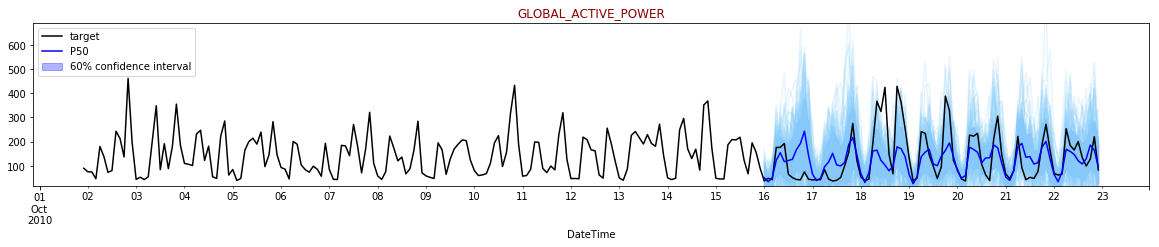

<Figure size 432x288 with 0 Axes>

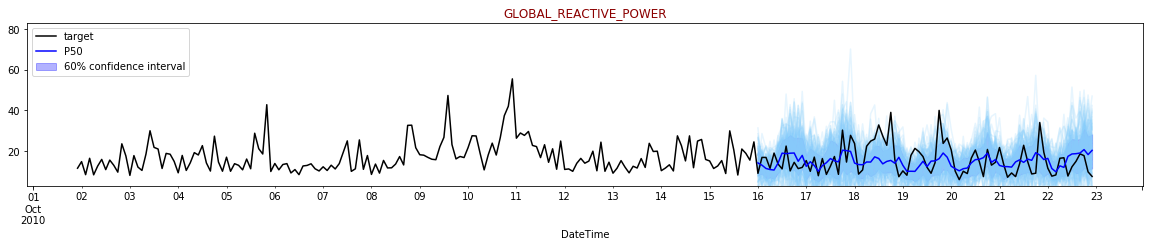

<Figure size 432x288 with 0 Axes>

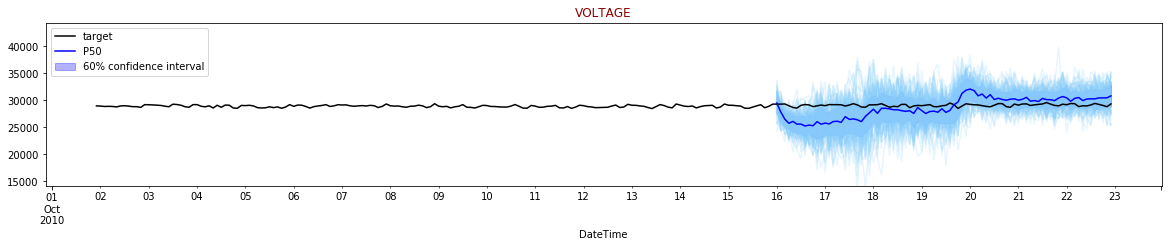

<Figure size 432x288 with 0 Axes>

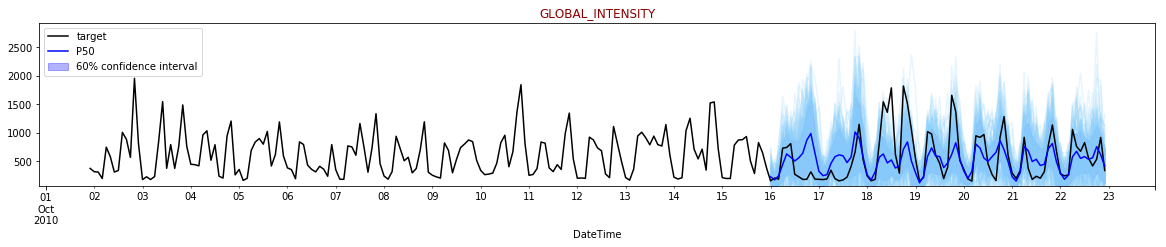

<Figure size 432x288 with 0 Axes>

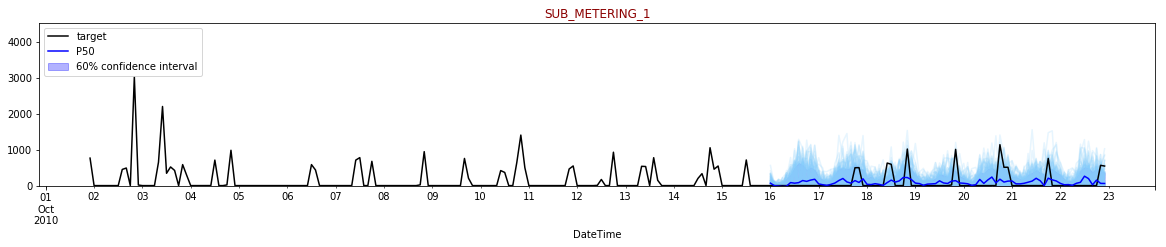

<Figure size 432x288 with 0 Axes>

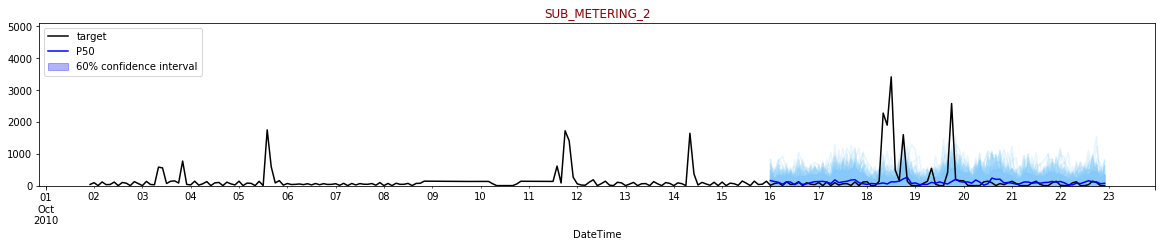

<Figure size 432x288 with 0 Axes>

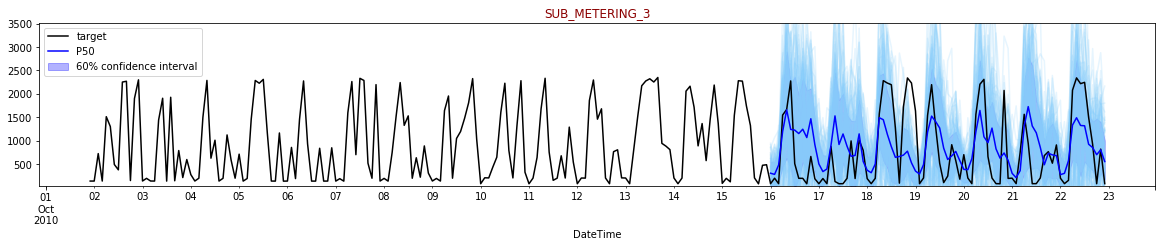

In [18]:
for i in range(len(time_series_training)):
    plt.figure()
    plot(
        predictor,
        target_ts=time_series[i],
        forecast_date=end_training,
        show_samples=True,
        plot_history= 2 * prediction_length,
        confidence=60,
    );

# Delete endpoint <a name="delete"></a>

Remember to delete your Amazon SageMaker endpoint once it is no longer needed. 

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [ ]:
predictor.delete_endpoint()

In [ ]:
whole_end = time.time()
print('Whole notebook elapsed time (min):', (whole_end-whole_start)/60.)

## Lab Complete

Congratulations! You have completed this lab. To clean up your lab environment, do the following:

1. To sign out of the AWS Management Console, click **awsstudent** at the top of the console, and then click **Sign Out**.
1. On the Qwiklabs page, click **End**.

<div style=\"text-align: right\"><b>END OF LAB</b></div>